## Framing the Problem
**Objective:** To detect the presence (or non-presence) of a causal impact of the time delay between a ServiceNow incident ticket being opened and its subsquent access (i.e. for initial triage) on the overall resolution time.

**Business Impact:**
Understanding the causal relationship between triage delay and resolution time can inform process improvements in incident management. Specifically, it can help determine whether targeted strategies to reduce initial triage times are worth the organizational resources to implement them.

**Findings Summary**:
Across various models and upon test sets, the average treatment effect of first access being over 12 hrs from ticket open was between a 30 to 40 hrs increase in time to resolve.

Accordingly, a costed analysis of this extra duration compared to triage management interventions appears warranted.

## Task 1 - Loading Key Libraries

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [4]:
# !pip install causalml

In [5]:
import causalml
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor
from sklearn.preprocessing import OrdinalEncoder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np

## Task 1.1 - Loading Data
As in assignment 1, a a ServiceNow™ incident management dataset is being used. The dataset is imported at a stage of minimal preprocessing as indicated by the commented code below. This preprocessing was done as part of assignment 1.

In [ ]:
# # Subset to only closed incidents
# all_data = pd.read_csv('incident_event_log.csv')
# incidents = all_data[all_data['incident_state'] == 'Closed'].copy()

# # Convert from log with multiple incident ID appearances to dataset where only the final log entry is kept
# # Copy all duplicated incidents to new dataframe
# incidents_dup = incidents[incidents['number'].duplicated(keep=False)].copy()

# # Convert sys_updated_at to datetime, with dayfirst=True
# incidents_dup['sys_updated_at'] = pd.to_datetime(incidents_dup['sys_updated_at'], dayfirst=True)

# # Get the unique incident numbers in incidents_dup
# dup_nums = incidents_dup['number'].unique()

# to_keep = []
# for num in dup_nums:
#     to_keep.append(incidents_dup[incidents_dup['number'] == num]['sys_updated_at'].idxmax())

# to_drop = []
# # get the index of all rows in incidents_dup other than those in to_keep
# for i in incidents_dup.index:
#     if i not in to_keep:
#         to_drop.append(i)

# # drop duplicate closed from incidents
# incidents.drop(to_drop, inplace=True)

# # Check for duplicates in "number" column
# incidents['number'].duplicated().sum()

# # Handle "?" in place of N/A values
# incidents.isin(['?']).sum(axis=0)
# incidents.replace('?', np.nan, inplace=True)
# incidents.isin(['?']).sum(axis=0)

# # Assign proper date-time data type
# date_cols = ['opened_at', 'sys_created_at', 'sys_updated_at', 'resolved_at', 'closed_at']

# # Convert columns in incidents to datetime
# for col in date_cols:
#     incidents[col] = pd.to_datetime(incidents[col], dayfirst=True)

# incidents.info()

# # Write to csv for causal inference task
# incidents.to_csv('incidents.csv', index=True)

**Data Dictionary**

In [83]:
file_path = '/content/drive/My Drive/Datasets/incidents-datadict.csv'
data_dict = pd.read_csv(file_path)

In [84]:
data_dict

,Variable Name,Variable Description
0,number,incident identifier
1,incident state,eight levels controlling the incident managem...
2,active,boolean attribute that shows whether the reco...
3,reassignment_count,number of times the incident has the group or...
4,reopen_count,number of times the incident resolution was r...
5,sys_mod_count,number of incident updates until that moment
6,made_sla,boolean attribute that shows whether the inci...
7,caller_id,identifier of the user affected
8,opened_by,identifier of the user who reported the incident
9,opened_at,incident user opening date and time


## Task 2 - Data Preparation & Feature Engineering for Causal Inference Task
Overall exploration was done in assignment 1. Thus, moving directly to requisite preprocessing to create treatment feature

In [12]:
file_path = '/content/drive/My Drive/Datasets/incidents.csv'
incidents_wip = pd.read_csv(file_path, index_col=0)
incidents_wip.head()

Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.


,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,...,False,Do Not Notify,NaN,NaN,NaN,NaN,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00
12,INC0000047,Closed,False,1,0,8,True,Caller 2403,Opened by 397,2016-02-29 04:40:00,...,False,Do Not Notify,NaN,NaN,NaN,NaN,code 5,Resolved by 81,2016-03-01 09:52:00,2016-03-06 10:00:00
19,INC0000057,Closed,False,0,0,6,True,Caller 4416,Opened by 8,2016-02-29 06:10:00,...,False,Do Not Notify,Problem ID 2,NaN,NaN,NaN,code 10,Resolved by 5,2016-03-01 02:55:00,2016-03-06 03:00:00
23,INC0000060,Closed,False,0,0,3,True,Caller 4491,Opened by 180,2016-02-29 06:38:00,...,False,Do Not Notify,NaN,NaN,NaN,NaN,code 3,Resolved by 113,2016-03-02 12:06:00,2016-03-07 13:00:00
31,INC0000062,Closed,False,1,0,7,False,Caller 3765,Opened by 180,2016-02-29 06:58:00,...,False,Do Not Notify,NaN,NaN,NaN,NaN,code 7,Resolved by 62,2016-02-29 15:51:00,2016-03-05 16:00:00


In [25]:
# load initial dataset
file_path = '/content/drive/My Drive/Datasets/incident_event_log.csv'
incident_log = pd.read_csv(file_path)
# check data types in initial dataset
incident_log.dtypes

number                     object
incident_state             object
active                       bool
reassignment_count          int64
reopen_count                int64
sys_mod_count               int64
made_sla                     bool
caller_id                  object
opened_by                  object
opened_at                  object
sys_created_by             object
sys_created_at             object
sys_updated_by             object
sys_updated_at             object
contact_type               object
location                   object
category                   object
subcategory                object
u_symptom                  object
cmdb_ci                    object
impact                     object
urgency                    object
priority                   object
assignment_group           object
assigned_to                object
knowledge                    bool
u_priority_confirmation      bool
notify                     object
problem_id                 object
rfc           

## Task 2.1 Cleaning Data

In [10]:
incident_log.replace('?', np.nan, inplace=True)
incident_log.isin(['?']).sum(axis=0)

number                     0
incident_state             0
active                     0
reassignment_count         0
reopen_count               0
sys_mod_count              0
made_sla                   0
caller_id                  0
opened_by                  0
opened_at                  0
sys_created_by             0
sys_created_at             0
sys_updated_by             0
sys_updated_at             0
contact_type               0
location                   0
category                   0
subcategory                0
u_symptom                  0
cmdb_ci                    0
impact                     0
urgency                    0
priority                   0
assignment_group           0
assigned_to                0
knowledge                  0
u_priority_confirmation    0
notify                     0
problem_id                 0
rfc                        0
vendor                     0
caused_by                  0
closed_code                0
resolved_by                0
resolved_at   

In [15]:
date_cols = ['opened_at', 'sys_created_at', 'sys_updated_at', 'resolved_at', 'closed_at']

# Convert columns in incident_log to datetime
for col in date_cols:
    incident_log[col] = pd.to_datetime(incident_log[col], dayfirst=True)

# Verify the conversion by checking the data types again
incident_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   number                   141712 non-null  object        
 1   incident_state           141712 non-null  object        
 2   active                   141712 non-null  bool          
 3   reassignment_count       141712 non-null  int64         
 4   reopen_count             141712 non-null  int64         
 5   sys_mod_count            141712 non-null  int64         
 6   made_sla                 141712 non-null  bool          
 7   caller_id                141683 non-null  object        
 8   opened_by                136877 non-null  object        
 9   opened_at                141712 non-null  datetime64[ns]
 10  sys_created_by           88636 non-null   object        
 11  sys_created_at           88636 non-null   datetime64[ns]
 12  sys_updated_by  

## Task 2.2 Create New Feature to Support Causal Inference
Calculating hours from ticket open to subsequent recorded update in system.

In [16]:
# Group by 'number' and then sort within each group by 'sys_updated_at'
# Then, get the second entry only if there are at least two updates
second_earliest_update = incident_log.sort_values('sys_updated_at').groupby('number').nth(1).reset_index()

# Rename the 'sys_updated_at' column to 'second_earliest_update' for clarity
second_earliest_update.rename(columns={'sys_updated_at': 'second_earliest_update'}, inplace=True)

# Merge the second earliest update information with the 'incidents_wip' DataFrame
# 'how=left' ensures that all entries in 'incidents_wip' are kept, even if there's no match in 'second_earliest_update'
incidents_wip = incidents_wip.merge(second_earliest_update[['number', 'second_earliest_update']], on='number', how='left')

# Now, 'incidents_wip' has a new column 'second_earliest_update' with the second earliest update time where available
# Let's check the result
print(incidents_wip.head())

       number  reassignment_count  reopen_count  sys_mod_count  made_sla  \
0  INC0000045                   0             0              4      True   
1  INC0000047                   1             0              8      True   
2  INC0000057                   0             0              6      True   
3  INC0000060                   0             0              3      True   
4  INC0000062                   1             0              7     False   

            opened_at      priority  knowledge  rfc         resolved_at  \
0 2016-02-29 01:16:00  3 - Moderate       True  NaN 2016-02-29 11:29:00   
1 2016-02-29 04:40:00  3 - Moderate       True  NaN 2016-03-01 09:52:00   
2 2016-02-29 06:10:00  3 - Moderate       True  NaN 2016-03-01 02:55:00   
3 2016-02-29 06:38:00  3 - Moderate       True  NaN 2016-03-02 12:06:00   
4 2016-02-29 06:58:00      2 - High       True  NaN 2016-02-29 15:51:00   

            closed_at second_earliest_update  
0 2016-03-05 12:00:00    2016-02-29 08:53:00 

Dropping columns which, through Assignmenrt 1 EDA were identified for removal due to: constant / near constant values that carry little information, redundant and/or have a high proportion of missing values, high correlation (0.9 threshold) with columns being kept, too many distinct categories and no domain knowledge to group them as they are masked as numbers (e.g. Location 123)

### Task 2.2.1 Additional Cleaning & Aligning Data Types

In [13]:
to_drop = ['incident_state', 'active', 'contact_type', 'sys_created_by', 'cmdb_ci', 'caused_by', 'closed_code', 'impact', 'urgency', 'vendor',
 'u_priority_confirmation', 'u_symptom', 'opened_by','assignment_group', 'assigned_to','problem_id', 'subcategory', 'resolved_by', 'caller_id', 'location', 'category',
  'sys_updated_by', 'notify', 'sys_created_at', 'sys_updated_at']

# drop columns from incidents_wip
incidents_wip.drop(to_drop, axis=1, inplace=True)

In [17]:
date_cols = ['opened_at', 'resolved_at', 'closed_at', 'second_earliest_update']

# Convert columns in incidents_wip to datetime
for col in date_cols:
    incidents_wip[col] = pd.to_datetime(incidents_wip[col], dayfirst=True)

# Verify the conversion by checking the data types again
incidents_wip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24918 entries, 0 to 24917
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   number                  24918 non-null  object        
 1   reassignment_count      24918 non-null  int64         
 2   reopen_count            24918 non-null  int64         
 3   sys_mod_count           24918 non-null  int64         
 4   made_sla                24918 non-null  bool          
 5   opened_at               24918 non-null  datetime64[ns]
 6   priority                24918 non-null  object        
 7   knowledge               24918 non-null  bool          
 8   rfc                     176 non-null    object        
 9   resolved_at             23362 non-null  datetime64[ns]
 10  closed_at               24918 non-null  datetime64[ns]
 11  second_earliest_update  24918 non-null  datetime64[ns]
dtypes: bool(2), datetime64[ns](4), int64(3), objec

### Task 2.2.2 Computing target feature, causal feature base, and minimal data imputation

Note: Function includes data imputation for null values in resolved_at column. EDA in Assignment 1 revealed that this is nearly always the same time stamp as the closed_at time stamp

In [20]:
def col_compute(df):
    # Create a copy of the dataframe to avoid modifying the original data
    df_processed = df.copy()

    # Compute 'first_access_hrs' as the difference in hours between 'opened_at' and 'second_earliest_update'
    df_processed['first_access_hrs'] = (df_processed['second_earliest_update'] - df_processed['opened_at']).dt.total_seconds() / 3600

    # Impute resolved_at with closed_at times where missing as a reasonable proxy
    idx = df_processed[df_processed['resolved_at'].isnull()].index
    df_processed.loc[idx, 'resolved_at'] = df_processed.loc[idx, 'closed_at']

    # Create a new binary column 'rfc_inc' to indicate the presence of 'rfc'
    df_processed['rfc_inc'] = df_processed['rfc'].notnull().astype(int)

    # Map 'made_sla' and 'knowledge' boolean columns to integers
    df_processed['made_sla'] = df_processed['made_sla'].astype(int)
    df_processed['knowledge'] = df_processed['knowledge'].astype(int)

    # Compute time_to_resolve as the difference between resolved_at and opened_at
    # Ensure 'resolved_at' is in datetime format
    df_processed['time_to_resolve'] = (df_processed['resolved_at'] - df_processed['opened_at']).dt.total_seconds() / 3600

    # Drop columns that are no longer needed at the end of the function
    columns_to_drop = ['closed_at', 'rfc', 'resolved_at', 'opened_at', 'second_earliest_update']
    df_processed.drop(columns_to_drop, axis=1, inplace=True)

    return df_processed

In [26]:
incidents_processed = col_compute(incidents_wip)

In [27]:
# round time_to_resolve and first_access_hrs to 1 decimal place
incidents_processed['time_to_resolve'] = incidents_processed['time_to_resolve'].round(1)
incidents_processed['first_access_hrs'] = incidents_processed['first_access_hrs'].round(1)
incidents_processed.head()

,number,reassignment_count,reopen_count,sys_mod_count,made_sla,priority,knowledge,first_access_hrs,rfc_inc,time_to_resolve
0,INC0000045,0,0,4,1,3 - Moderate,1,7.6,0,10.2
1,INC0000047,1,0,8,1,3 - Moderate,1,0.8,0,29.2
2,INC0000057,0,0,6,1,3 - Moderate,1,0.5,0,20.8
3,INC0000060,0,0,3,1,3 - Moderate,1,50.2,0,53.5
4,INC0000062,1,0,7,0,2 - High,1,0.5,0,8.9


## Task 2.3 Categorical Encoding

Encoding of categorical priority column

In [28]:
# Define the categories
p_cats = ['4 - Low','3 - Moderate','2 - High', '1 - Critical' ]

# Initialize the encoder with the specified categories
oencoder = OrdinalEncoder(categories=[p_cats])

# Fit and transform the 'priority' column, then assign the result back to 'priority'
incidents_processed['priority'] = oencoder.fit_transform(incidents_processed[['priority']])

print(incidents_processed['priority'].head())

0    1.0
1    1.0
2    1.0
3    1.0
4    2.0
Name: priority, dtype: float64


## Task 2.4 Outlier Detection

In [29]:
from sklearn.ensemble import IsolationForest

In [30]:
# Create an instance of Isolation Forest
iforest = IsolationForest(n_estimators=100, contamination=0.01, random_state=4)

# Fit the model and obtain predictions
iforest.fit(incidents_processed[['time_to_resolve']])
outliers = iforest.predict(incidents_processed[['time_to_resolve']])
outliers = pd.Series(outliers, index=incidents_processed.index)

# Check the number of outliers
print(outliers.value_counts())

X does not have valid feature names, but IsolationForest was fitted with feature names


 1    24668
-1      250
dtype: int64


In [31]:
# Removing outliers in target
incidents_proc_1 = incidents_processed[outliers == 1]

In [32]:
# use isolation forest to check for outliers in first_access_hrs
# Fit the model and obtain predictions
iforest = IsolationForest()
iforest.fit(incidents_proc_1[['first_access_hrs']])

# Obtain predictions
outliers = iforest.predict(incidents_proc_1[['first_access_hrs']])
outliers = pd.Series(outliers, index=incidents_proc_1.index)

# Check the number of outliers
print(outliers.value_counts())

 1    21814
-1     2854
dtype: int64


In [33]:
# Removing access hrs outliers
incidents_proc_2 = incidents_proc_1[outliers == 1]

## Task 2.5 Additional EDA with New Feature

In [34]:
# Writing file to csv for local use of ydataprofiling for additional EDA

file_path = '/content/drive/My Drive/Datasets/incidents_proc_2.csv'

incidents_proc_2.to_csv(file_path, index=True) 

print(f'File saved to {file_path}')

# html file Incident_Profiling_Causal_2 

File saved to /content/drive/My Drive/Datasets/incidents_proc_2.csv


## Task 2.6 Engineering Binary Treatment Feature
From EDA on the feature representing hours to first ticket access, the minimum is 0, maximum is 121, and mean is aprox 10 hrs (9.8).
CausalML will be leveraged to assess the ATE of over 12 hours elapsing before first ticket access.

In [35]:
incidents_proc_2.loc[:, 'over_12'] = (incidents_proc_2['first_access_hrs'] > 12).astype(int)
incidents_proc_2.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,number,reassignment_count,reopen_count,sys_mod_count,made_sla,priority,knowledge,first_access_hrs,rfc_inc,time_to_resolve,over_12
0,INC0000045,0,0,4,1,1.0,1,7.6,0,10.2,0
1,INC0000047,1,0,8,1,1.0,1,0.8,0,29.2,0
2,INC0000057,0,0,6,1,1.0,1,0.5,0,20.8,0
4,INC0000062,1,0,7,0,2.0,1,0.5,0,8.9,0
5,INC0000063,1,0,7,1,1.0,1,0.2,0,8.9,0


## Task 3.0 Deriving Average Treatment Effect with CausalML

A subset of features are selected for this task. The target is time to resolve ticket (in hours). The treatment is whether or not the time to first ticket access was over 12 hrs. The other features are sys_mod_count, priority, knowledge, rfc_inc.

Reassignment count and reopen count are not included due to a correlation above the 0.9 threshold. The ticket ID is not included but preserved for future enrichment of dataset from original log data. The made_sla feature would leak information and is thus excluded from this analysis but preserved for potential classification analysis with dataset in the future.

In [36]:
incidents_df = incidents_proc_2.copy()

In [37]:
X = incidents_df[['sys_mod_count', 'priority', 'knowledge', 'rfc_inc']]
y = incidents_df['time_to_resolve']
treatment = incidents_df['over_12']

### Task 3.1 SLearner and TLearner Derivations

In [38]:
# SLearner
lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): 102.68 (96.36, 109.01)


The S-Learner, which uses a single base learner with the treatment as a feature estimated the average effect of the first ticket access being over 12 hours is in increase of 102 hours in time to resolve.

The thirs quartile for time to resolve is 120 hours. Thus, in context the figure is not implausible. However, the assumption of a linear relationship would not reflect reality.

In [39]:
# TLearner
xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (XGBoost): 39.30 (35.33, 43.26)


The XGBoost T-Learner, which has a base learner for the treatment and the control group, estimated an ATE of 39 hours. This figure appears more plausible for the effect of this single treatment.

### Task 3.1.1 ATE Derivations with Controls
Subsetting data to only medium priority tickets (1.0 in ordinal encoding)

In [40]:
med_incidents = incidents_df.copy()
med_incidents = med_incidents[med_incidents['priority'] == 1.0]

In [41]:
X = med_incidents[['sys_mod_count', 'priority', 'knowledge', 'rfc_inc']]
y = med_incidents['time_to_resolve']
treatment = med_incidents['over_12']

In [42]:
# SLearner
lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): 101.51 (95.01, 108.01)


In [43]:
# TLearner
xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (XGBoost): 36.04 (31.96, 40.12)


When controlling for the priority of the ticket, the derived ATE is slightly lower but still comparable to the previous derivations.

Now subsetting to only high or critical tickets to observe level of heterogeneity in treatment effects.

In [47]:
hc_incidents = incidents_df.copy()
hc_incidents = hc_incidents[(hc_incidents['priority'] == 2.0) | (hc_incidents['priority'] == 3.0)]

In [48]:
X = hc_incidents[['sys_mod_count', 'priority', 'knowledge', 'rfc_inc']]
y = hc_incidents['time_to_resolve']
treatment = hc_incidents['over_12']

In [49]:
# SLearner
lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): 130.12 (66.13, 194.10)


In [50]:
# TLearner
xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (XGBoost): 117.02 (94.94, 139.10)


The ATE for high and critical tickets is vastly different, especially in the case of the T-Learner. There are significantly fewer observations for these cases. However this wide gap in the derived ATEs suggests that the priority, which incorporates both impact and urgency, may actually be a confounding factor.

In [51]:
print(f"Number of medium incidents: {med_incidents.shape}")
print(f"Number of high and critical incidents: {hc_incidents.shape}")

Number of medium incidents: (20503, 11)
Number of high and critical incidents: (618, 11)


### Task 3.2 Comparison of ATE Stability
Using the medium priority incidents and lightGBM

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X = med_incidents.drop(columns=['time_to_resolve'])
y = med_incidents['time_to_resolve']

# Split the dataset into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [54]:
treatment_train = X_train['over_12']
treatment_test = X_test['over_12']

X_train = X_train.drop(columns=['over_12'])
X_test = X_test.drop(columns=['over_12'])

In [60]:
X_train = X_train[['sys_mod_count', 'priority', 'knowledge', 'rfc_inc']]
X_test = X_test[['sys_mod_count', 'priority', 'knowledge', 'rfc_inc']]

In [55]:
from lightgbm import LGBMRegressor

In [57]:
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor

In [64]:
learner = LGBMRegressor(verbosity=-1)
learner_t = BaseTRegressor(learner=learner, control_name=0)
ate_train, _, _ = learner_t.estimate_ate(X=X_train, treatment=treatment_train, y=y_train)

In [65]:
# Get ATE for test data
te_test= learner_t.predict(X=X_test)
ate_test = te_test.mean(axis=0)[0]

print(f"Train ATE: {ate_train[0]:.2f}")
print(f"Test ATE: {ate_test:.2f}")

Train ATE: 38.07
Test ATE: 38.04


There is a good level of stability between the train and test ATEs. The derived ATE also resembles that derived with the XGBoost Learner

## Task 4.0 Feature Importances

In [66]:
# Ensuring the med_incidents configuration is being used
X = med_incidents[['sys_mod_count', 'priority', 'knowledge', 'rfc_inc']]
y = med_incidents['time_to_resolve']
treatment = med_incidents['over_12']

In [67]:
w_multi = np.array(['over_12' if x == 1 else 'control' for x in treatment])

In [68]:
slearner = BaseSRegressor(LGBMRegressor(), control_name='control')
slearner.estimate_ate(X, w_multi, y)
slearner_tau = slearner.fit_predict(X, w_multi, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 20503, number of used features: 4
[LightGBM] [Info] Start training from score 106.276374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 20503, number of used features: 4
[LightGBM] [Info] Start training from score 106.276374


In [69]:
from sklearn.ensemble import RandomForestRegressor

In [71]:
# Adding treatment back, in order to have it displayed in feature importance plot
X2 = X.copy()
X2['over_12'] = treatment
print(X2.head())

   sys_mod_count  priority  knowledge  rfc_inc  over_12
0              4       1.0          1        0        0
1              8       1.0          1        0        0
2              6       1.0          1        0        0
5              7       1.0          1        0        0
6              8       1.0          1        0        0


In [72]:
model_tau_feature = RandomForestRegressor()
slearner.get_importance(X=X2, tau=slearner_tau, model_tau_feature=model_tau_feature,
normalize=True, method='auto', features= [X2.columns])

{'over_12': sys_mod_count    0.911543
 knowledge        0.077925
 rfc_inc          0.010510
 over_12          0.000022
 priority         0.000000
 dtype: float64}

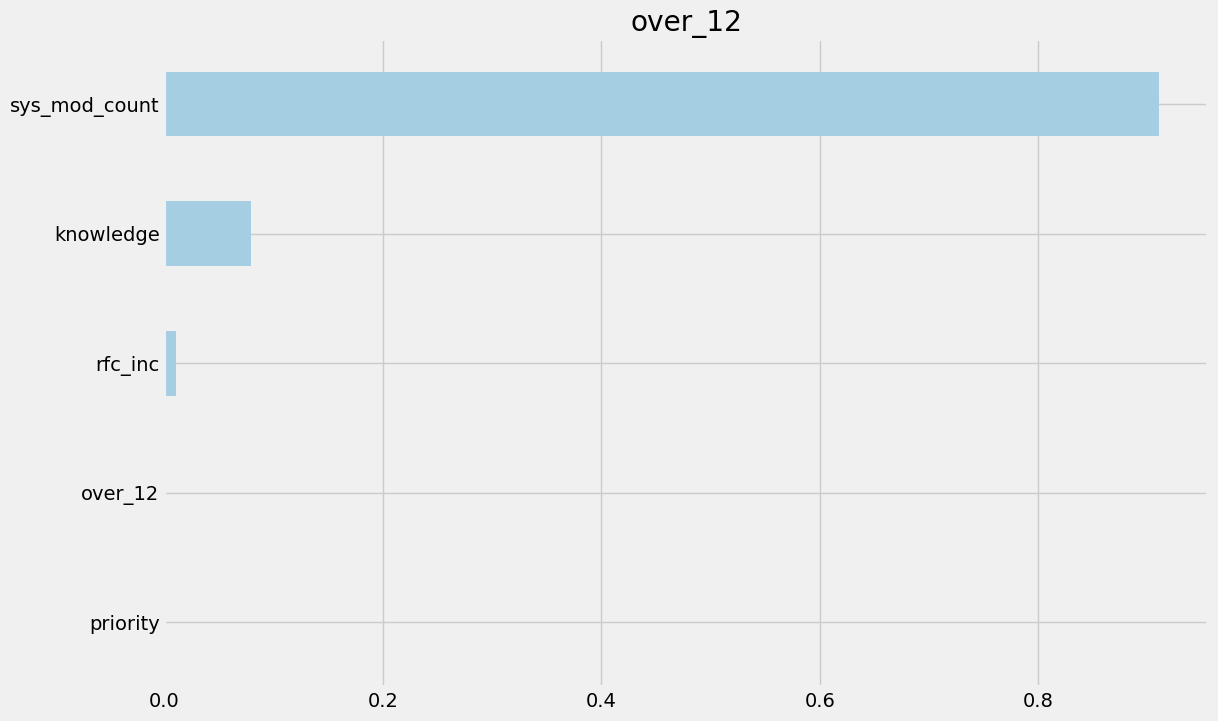

In [74]:
slearner.plot_importance(X=X2, tau=slearner_tau, normalize=True, model_tau_feature=model_tau_feature, method='auto', features=X2.columns)

The system modification count is displaying the highest feature importance to the target. However, this is not something that can or should really be manipulated as a treatment. It can capture some information about how much attention a ticket is getting. At the same time, in many cases it would naturally increase the longer a ticket is open. It's a similar story with rfc_inc. Whether or not an incident is related to an RFC isn't something that can be adjusted.

However, the importance of the knowledge variable is intriguing. There's a potential that referencing existing knowledge base documents is an underutilized method for closing incidents more quickly.

In [75]:
slearner.get_importance(X=X2, tau=slearner_tau, model_tau_feature=model_tau_feature,
normalize=True, method='permutation', features= [X2.columns])

{'over_12': sys_mod_count    1.940451
 knowledge        0.380246
 rfc_inc          0.012512
 over_12          0.000084
 priority         0.000000
 dtype: float64}

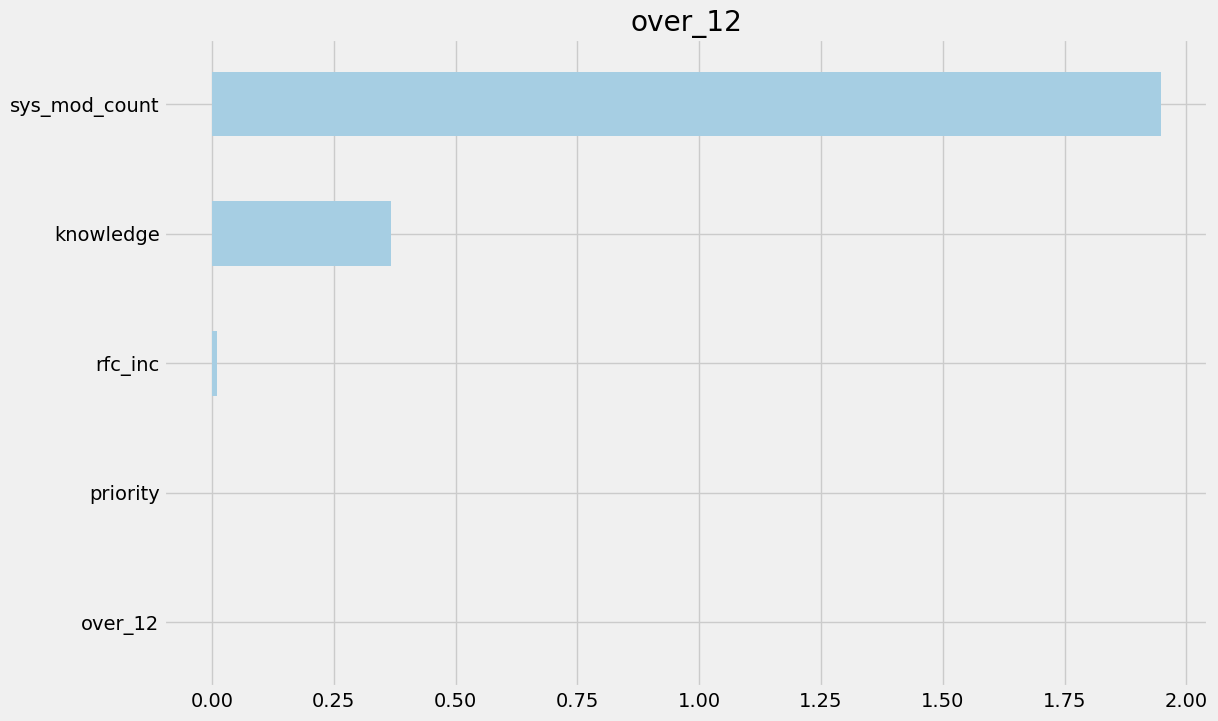

In [76]:
slearner.plot_importance(X=X2, tau=slearner_tau, normalize=True, model_tau_feature=model_tau_feature, method='permutation', features=X2.columns)

After validating the importance of referencing knowledge documents through an additional feature importance method, an ATE estimation of this treatment is well warranted.

## Task 5.0 Assessing Alternate Treatment

In [77]:
med_incidents.head()

,number,reassignment_count,reopen_count,sys_mod_count,made_sla,priority,knowledge,first_access_hrs,rfc_inc,time_to_resolve,over_12
0,INC0000045,0,0,4,1,1.0,1,7.6,0,10.2,0
1,INC0000047,1,0,8,1,1.0,1,0.8,0,29.2,0
2,INC0000057,0,0,6,1,1.0,1,0.5,0,20.8,0
5,INC0000063,1,0,7,1,1.0,1,0.2,0,8.9,0
6,INC0000064,1,0,8,1,1.0,1,0.1,0,80.8,0


In [78]:
X = med_incidents[['sys_mod_count', 'priority', 'first_access_hrs', 'rfc_inc']]
y = med_incidents['time_to_resolve']
treatment = med_incidents['knowledge']

In [79]:
# TLearner
xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (XGBoost): 2.19 (-1.91, 6.29)


In [80]:
# inverting treatment for easier interpretation
treatment = 1 - med_incidents['knowledge'] # 1 means knowledge base doc not used

In [81]:
# TLearner
xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (XGBoost): -2.19 (-6.29, 1.91)


According to this rapid assessment, the treatment of not accessing the knowledge docs has a mean impact of _reducing_ time to resolve. With a much smaller treatment effect and one which ranges from positive to negative, the earlier treatment identified still stands with the stronger case.